# Chuẩn bị


1. Tải Stockfish từ trang chính thức: https://stockfishchess.org/download/

2. Sau khi tải về, đổi tên file `.exe` thành `stockfish`

3. Di chuyển file này vào thư mục: `chess-bot/.venv/bin/`

4. Tải dataset từ https://www.kaggle.com/code/gabrielhaselhurst/chess-dataset/input

5. Di chuyển file này vào thư mục chess-bot

## Import thư viện cần thiết

In [1]:
from stockfish import Stockfish
import numpy as np
import matplotlib.pyplot as plt
import chess
import chess.svg
from typing import List
import pandas as pd
from IPython.display import display, SVG, HTML
import math
from evaluation.static_evaluation import evaluate_board


## Config đường dẫn

In [2]:
stockfish_path = "chess_venv/bin/stockfish"


## Stockfish Engine

In [5]:
stockfish = Stockfish(stockfish_path)
stockfish.set_skill_level(20)
stockfish.set_depth(20)

In [6]:
def get_stockfish_score(fen: str) -> float:
    stockfish.set_fen_position(fen)
    score = stockfish.get_evaluation()
    return score["value"] if score["type"] == "cp" else (1000 if score["value"] > 0 else -1000)

## Lấy tập dữ liệu

In [7]:
df = pd.read_csv('chessData.csv')
df.head()

,FEN,Evaluation
0,rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...,-10
1,rnbqkbnr/pppp1ppp/4p3/8/4P3/8/PPPP1PPP/RNBQKBN...,+56
2,rnbqkbnr/pppp1ppp/4p3/8/3PP3/8/PPP2PPP/RNBQKBN...,-9
3,rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPP2PPP/RNBQKB...,+52
4,rnbqkbnr/ppp2ppp/4p3/3p4/3PP3/8/PPPN1PPP/R1BQK...,-26


In [9]:
test_fens = df.sample(n=100, random_state=42)['FEN'].to_list()
stockfish_scores = (
    df.sample(n=100, random_state=42)['Evaluation']
    .astype(str)
    .str.replace("+", "", regex=False)  # Remove "+"
    .str.extract(r'([-]?\d+)')[0]       # Extract numbers (returns DataFrame, select column 0)
    .astype(float)
    .fillna(0)
    .astype(int)
    .tolist()  # Convert to Python list
)

print(stockfish_scores)
print(sum(stockfish_scores))

[-35, -201, 121, 280, 328, 74, -26, 43, -1285, 296, -360, 1087, -806, 0, 243, -252, 680, 784, -4795, 20, -72, -159, -78, 53, 492, 47, -319, 42, 78, 85, -128, 682, -22, 746, 5454, 0, 440, -240, 76, 53, -19, -50, -533, -779, 0, 388, -139, 3, 523, 2238, -374, -49, 0, -337, 78, -88, 470, 94, 100, 119, -322, 124, 0, -17, -153, 703, -59, 71, 73, 72, -70, 45, 0, 246, 13, 161, -66, -6934, -61, -54, -26, -338, 0, 155, 173, 384, -433, 0, 192, -27, -50, -13, 365, 0, -101, 175, 125, 6061, 76, 64]
5625


## Visualization

In [10]:
def showBoard(fens, boards_per_row=5):
    total_boards = len(fens)
    rows = math.ceil(total_boards / boards_per_row)
    
    for row in range(rows):
        boards_in_row = []
        for col in range(boards_per_row):
            idx = row * boards_per_row + col
            if idx < total_boards:
                board = chess.Board(fens[idx])
                svg = chess.svg.board(board, size=200)  # Giảm size nếu cần
                boards_in_row.append(SVG(svg)._repr_svg_())  # Lấy chuỗi SVG
        
        # Tạo HTML với flexbox để xếp hàng ngang
        html = f"""
        <div style="display: flex; flex-wrap: nowrap; gap: 10px; margin: 10px 0;">
            {''.join(boards_in_row)}
        </div>
        """
        display(HTML(html))

In [11]:
showBoard(df.sample(n=50, random_state=42)['FEN'].to_list())

# 1. Initialization

In [14]:
def initialize_population(size: int):
    """
    Initialize a population with chess-specific value ranges.

    Args:
        size (int): Number of individuals in the population.

    Returns:
        np.ndarray: Population matrix (size, num_params) with meaningful bounds.
    """
    # Define bounds for each gene type
    bounds = np.array([
        [-5, 5],   # Evaluation Weight: Material
        [-5, 5],   # Evaluation Weight: King Safety
        [-5, 5],   # Evaluation Weight: Pawn Structure
        [-5, 5],   # Evaluation Weight: Mobility
        [-5, 5],   # Evaluation Weight: Center Control
        [80, 120],   # Pawn Value
        [270, 350],  # Knight Value
        [300, 350],  # Bishop Value
        [450, 550],  # Rook Value
        [850, 1050], # Queen Value
        [9000, 12000], # King Value
        [0, 30],  # Doubled Pawn Penalty
        [0, 30],  # Isolated Pawn Penalty
        [0, 50],   # King Safety Multiplier
        [0, 10],   # Mobility Multiplier
        [0, 20]    # Center Control Multiplier
    ])

    # Generate random values within bounds
    low, high = bounds[:, 0], bounds[:, 1]
    population = np.random.uniform(low=low, high=high, size=(size, len(bounds)))

    return population

print(initialize_population(200))

[[-1.16905044e+00 -3.49787237e+00 -2.13003202e+00 ...  3.04723581e+01
   1.44383930e+00  1.20469443e+01]
 [ 4.21923160e+00  2.09468283e-02  2.36336806e+00 ...  1.42445085e+01
   6.93847124e+00  1.75060071e+00]
 [ 3.27058841e+00 -3.44503729e-01 -2.29567372e+00 ...  1.99009343e+01
   8.46309220e+00  1.62496463e+01]
 ...
 [ 3.85019561e+00  4.00200944e+00  1.04822578e+00 ...  4.71241217e+01
   5.39257021e+00  1.31189437e+01]
 [-2.75244682e+00 -4.69142539e-01  1.96298091e+00 ...  2.53748835e+01
   7.89406194e+00  8.59392860e+00]
 [-4.69390848e+00  2.99908301e+00  4.35055790e+00 ...  4.71908818e+01
   3.85730360e+00  1.97442839e+01]]


# Fitness function

In [15]:
def fitness_function(weights: List[float]) -> float:
    total_error = 0
    for fen, sf_score in zip(test_fens, stockfish_scores):
        eval_score = evaluate_board(fen, weights)
        total_error += abs(eval_score - sf_score)
    return -total_error  # Càng gần giá trị của Stockfish thì fitness càng cao

# Selection

In [16]:
def tournament_selection(population, fitness_scores, tournament_size=5):
    """
    Selects a parent using tournament selection.

    Args:
        population (np.array): Population of individuals.
        fitness_scores (np.array): Fitness scores of individuals.
        tournament_size (int): Number of individuals in the tournament.

    Returns:
        np.array: Selected individual.
    """
    selected_indices = np.random.choice(len(population), tournament_size, replace=False)
    best_index = selected_indices[np.argmax(fitness_scores[selected_indices])]
    return population[best_index]

# Crossover

In [17]:
def crossover_blx_alpha(parent1, parent2, alpha=0.4):
    """
    Perform BLX-α crossover to blend weights from two parents.
    
    Args:
        parent1 (np.array): First parent weights.
        parent2 (np.array): Second parent weights.
        alpha (float): Exploration parameter (0.0 - 0.5 recommended).

    Returns:
        np.array: Child weights.
    """
    p1, p2 = np.array(parent1), np.array(parent2)
    min_vals = np.minimum(p1, p2)
    max_vals = np.maximum(p1, p2)
    range_vals = max_vals - min_vals
    
    # Generate offspring within blended range
    child = min_vals - alpha * range_vals + np.random.rand(len(p1)) * (1 + 2 * alpha) * range_vals
    return np.clip(child, -1, 1)  # Keep values in range

# Mutation

In [18]:
def mutate_gaussian(individual, mutation_rate=0.3, mutation_strength=0.1):
    """
    Apply Gaussian mutation to perturb weights slightly.

    Args:
        individual (np.array): Weights of an individual.
        mutation_rate (float): Probability of each weight mutating.
        mutation_strength (float): Standard deviation of Gaussian noise.

    Returns:
        np.array: Mutated weights.
    """
    mutation_mask = np.random.rand(len(individual)) < mutation_rate
    mutation_values = np.random.normal(0, mutation_strength, size=len(individual))
    individual[mutation_mask] += mutation_values[mutation_mask]
    return np.clip(individual, -1, 1)  # Keep values in range

In [19]:
def adaptive_mutation_rate(generation, total_generations, min_rate=0.05, max_rate=0.3):
    """
    Decreases mutation rate over generations to balance exploration and exploitation.
    """
    return max_rate - (max_rate - min_rate) * (generation / total_generations)

In [20]:
def adaptive_mutation_strength(generation, total_generations, min_strength=0.01, max_strength=0.2):
    """
    Decreases mutation strength over generations.
    """
    return max_strength - (max_strength - min_strength) * (generation / total_generations)

# GA

In [22]:
import numpy as np

def genetic_algorithm(
    fitness_function, 
    population_size=50, 
    generations=200, 
    elite_size=10, 
    tournament_size=5, 
    convergence_threshold=20  # Stop if no improvement for X generations
):
    """
    Runs an optimized Genetic Algorithm with early stopping when convergence is detected.

    Args:
        fitness_function (function): Function to evaluate individuals.
        population_size (int): Number of individuals in the population.
        generations (int): Max number of generations.
        elite_size (int): Number of top individuals to retain.
        mutation_rate (float): Probability of mutation.
        mutation_strength (float): Mutation intensity.
        tournament_size (int): Tournament selection group size.
        convergence_threshold (int): Stop early if best fitness does not improve for this many generations.

    Returns:
        np.ndarray: Best found individual.
        list: Fitness score history.
    """
    # Initialize population with random genes
    population = initialize_population(population_size)
    best_fitness_history = []
    best_fitness = -np.inf  # Store best fitness found
    no_improvement_count = 0  # Track stagnation

    for generation in range(generations):
        # Evaluate fitness for all individuals
        fitness_scores = np.array([fitness_function(ind) for ind in population])
        mutation_rate = adaptive_mutation_rate(generation, generations)
        mutation_strength = adaptive_mutation_strength(generation, generations)


        # Sort and keep top elite individuals
        sorted_indices = np.argsort(fitness_scores)[::-1]  # Sort descending
        elite = population[sorted_indices[:elite_size]]

        # Track best fitness
        current_best_fitness = fitness_scores[sorted_indices[0]]
        best_fitness_history.append(current_best_fitness)

        # Check if fitness improved
        if current_best_fitness > best_fitness:
            best_fitness = current_best_fitness
            no_improvement_count = 0  # Reset stagnation counter
        else:
            no_improvement_count += 1  # Increment stagnation counter

        # Stop early if fitness has not improved in `convergence_threshold` generations
        if no_improvement_count >= convergence_threshold:
            print(f"✅ Converged after {generation+1} generations! Stopping early.")
            break

        # Generate new population
        new_population = []
        for _ in range(population_size - elite_size):
            p1 = tournament_selection(population, fitness_scores, tournament_size)
            p2 = tournament_selection(population, fitness_scores, tournament_size)
            child = crossover_blx_alpha(p1, p2)
            child = mutate_gaussian(child, mutation_rate, mutation_strength)
            new_population.append(child)

        # Create next generation
        population = np.vstack((elite, new_population))

        print(f"Generation {generation+1}: Best Fitness = {current_best_fitness:.3f}")

    return population[0], best_fitness_history


# Tuning

Generation 1: Best Fitness = -44968.644
Generation 2: Best Fitness = -44968.644
Generation 3: Best Fitness = -44968.644
Generation 4: Best Fitness = -44968.644
Generation 5: Best Fitness = -44968.644
✅ Converged after 6 generations! Stopping early.


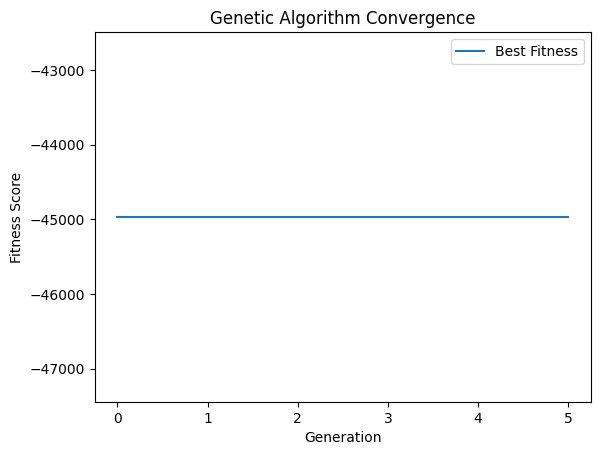

Optimized Weights: [3.66738021e-01 4.34611422e+00 3.19682972e+00 1.94230774e+00
 3.87857390e+00 1.02491726e+02 3.08043377e+02 3.22308484e+02
 4.74283159e+02 9.12774500e+02 9.07712300e+03 1.94412397e+01
 1.28202825e+01 2.62151959e+00 2.91134420e-01 9.47975024e+00]
Suggested weights fitness: -47341.5


In [25]:
best_weights, best_fitness_history = genetic_algorithm(fitness_function, population_size=50, generations=500, convergence_threshold=5)

# Plot Convergence Graph
plt.plot(best_fitness_history, label="Best Fitness")
plt.xlabel("Generation")
plt.ylabel("Fitness Score")
plt.title("Genetic Algorithm Convergence")
plt.legend()
plt.show()

print("Optimized Weights:", best_weights)

chromosomes = [
                1.0, 0.8, -1.2, 0.7, 1.15,
                100, 300, 320, 500, 900, 10000,
                10, 10,
                20,
                5,
                10
            ]
print("Suggested weights fitness:", fitness_function(chromosomes))